<a href="https://colab.research.google.com/github/atalaydenknalbant/ML-Displacement-Detection/blob/main/TF_Displacement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dnn Regression For the Predicting Displacement of the Construction**

# Importing Libraries

In [ ]:
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
!pip install imbalanced-learn
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling



  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-isaqx_92
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-isaqx_92
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01c7f2ed3be65e70f7bcd10a435ef9d1b3c313db4_-cp36-none-any.whl size=119609 sha256=008439c6db4c2cc44ce65c230a9281a1b968ccdb666aa8c3e27e490176b09ada
  Stored in directory: /tmp/pip-ephem-wheel-cache-s9uz4sk1/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


#Authorizing admin for firebase(Upload Service Key)

In [ ]:
import ipywidgets

uploader = ipywidgets.FileUpload(
    accept='.json',
    multiple=False
)
service_acct_file = {}
def handle_upload(change):
    service_acct_file['name'] = next(iter(change['owner'].value))
    service_acct_file['data'] = change['owner'].value[service_acct_file['name']]['content']
    with open(service_acct_file['name'], 'wb') as f:
        f.write(service_acct_file['data'])
    print('Uploaded {}'.format(service_acct_file['name']))
uploader.observe(handle_upload, names='data')
display(uploader)


FileUpload(value={}, accept='.json', description='Upload')

Uploaded service_key.json


## Setting Google Credentials Location

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.realpath(service_acct_file['name'])

## Initialize Bucket


In [ ]:
#Give a name to storage bucket
storage_bucket = input('Storage bucket (no "gs://capstone-d65e8.appspot.com"): ')

Storage bucket (no "gs://capstone-d65e8.appspot.com"): 


## Initiliaze Admin

In [ ]:
import firebase_admin
from firebase_admin import ml
try:
  firebase_admin.initialize_app(options={'storageBucket': storage_bucket})
except ValueError:
  print("Firebase already initiated")



# Importing Json data into Dataframe

## Vibration Data

##If firestore quota exceeded

In [ ]:
import ipywidgets

uploader = ipywidgets.FileUpload(
    accept='.csv',
    multiple=False
)
vibration_data = {}
def handle_upload(change):
    vibration_data['name'] = next(iter(change['owner'].value))
    vibration_data['data'] = change['owner'].value[vibration_data['name']]['content']
    with open(vibration_data['name'], 'wb') as f:
        f.write(vibration_data['data'])
    
uploader.observe(handle_upload, names='data')
display(uploader)


FileUpload(value={}, accept='.csv', description='Upload')

In [ ]:
df_vibration = pd.read_csv(os.path.realpath(vibration_data['name']))
df_vibration.head()

Period            UX        UY  ...     SumRX    SumRY         SumRZ
0  2.862372  2.042000e-05  0.000063  ...  0.000014  0.17743  7.310000e-09
1  2.848575  2.225000e-05  0.000049  ...  0.000030  0.39074  3.760000e-08
2  2.291221  8.200000e-10  0.630250  ...  0.262810  0.39074  7.320000e-08
3  1.789684  1.932000e-06  0.000990  ...  0.303380  0.39167  8.850000e-08
4  1.785447  9.730000e-07  0.001910  ...  0.379110  0.39214  1.650000e-07

[5 rows x 13 columns]

##If firestore quota not exceeded

In [ ]:
from firebase_admin import firestore
db = firestore.client()
vibration_data_dict = {}
i=1
while i<13:
  doc_ref = db.collection(u'vibration_data').document(str(i))

  doc = doc_ref.get()
  vibration_data_dict[i] = doc.to_dict()
  i+=1
df_vibration = pd.DataFrame.from_dict(vibration_data_dict,orient='index')
df_vibration.head()  



UX        UY        UZ  ...    SumRY         SumRZ    Period
1  2.042000e-05  0.000063  0.264390  ...  0.17743  7.311000e-09  2.862372
2  2.225000e-05  0.000049  0.217650  ...  0.39074  3.764000e-08  2.848575
3  8.196000e-10  0.630250  0.000021  ...  0.39074  7.318000e-08  2.291221
4  1.932000e-06  0.000990  0.000280  ...  0.39167  8.852000e-08  1.789684
5  9.726000e-07  0.001910  0.000590  ...  0.39214  1.650000e-07  1.785447

[5 rows x 13 columns]

## Arduino Data

##If firestore  quota exceeded

In [ ]:
import ipywidgets

uploader = ipywidgets.FileUpload(
    accept='.json',
    multiple=False
)
arduino_data = {}
def handle_upload(change):
    arduino_data['name'] = next(iter(change['owner'].value))
    arduino_data['data'] = change['owner'].value[arduino_data['name']]['content']
    with open(arduino_data['name'], 'wb') as f:
        f.write(arduino_data['data'])
    
uploader.observe(handle_upload, names='data')
display(uploader)


FileUpload(value={}, accept='.json', description='Upload')

In [ ]:
df_arduino = pd.read_json(os.path.realpath(arduino_data['name']))
df_arduino.head()

Period     UX     UY     UZ   SumUX  SumUY  SumUZ
0       0  26.61  12.84  22.73   391.5   63.0  223.0
1     140  24.46  11.52  22.73   240.0   56.5  223.0
2     243  79.10  88.89  74.41  1164.0  872.0  365.0
3     347  87.67  98.27  83.49  1290.0  964.0  819.0
4     450  37.82  23.85  40.37   185.5  234.0  396.0

##If firestore quota not exceeded

In [ ]:
arduino_data_dict = {}
docs = db.collection(u'arduino_data').stream()
i=0
for doc in docs:
    arduino_data_dict[int(doc.id)] = doc.to_dict()
    i+=1   
df_arduino = pd.DataFrame.from_dict(arduino_data_dict,orient='index')


#Pre-processing

In [ ]:
df_vibration.isnull().sum()

RX        0
RY        0
RZ        0
SumRX     0
SumRY     0
SumRZ     0
Period    0
UX        0
UY        0
UZ        0
SumUX     0
SumUY     0
SumUZ     0
dtype: int64

In [ ]:
df_arduino.isnull().sum()

SumUX     0
SumUY     0
SumUZ     0
Period    0
UX        0
UY        0
UZ        0
dtype: int64

In [ ]:
df_vibration.count()

RX        12
RY        12
RZ        12
SumRX     12
SumRY     12
SumRZ     12
Period    12
UX        12
UY        12
UZ        12
SumUX     12
SumUY     12
SumUZ     12
dtype: int64

In [ ]:
df_arduino.count()

SumUX     1300
SumUY     1300
SumUZ     1300
Period    1300
UX        1300
UY        1300
UZ        1300
dtype: int64

#Over Sampling Vibration data

##Oversampling

In [ ]:
len(df_vibration)

12

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='all')
combined_df = df_vibration

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

for i in range(33):
  x_sumux = combined_df.drop(['SumUX'], axis=1)
  y_sumux = combined_df['SumUX']
  X_train, X_test, y_train, y_test = train_test_split(
                                                      x_sumux, y_sumux, 
                                                      test_size=0.2, 
                                                      random_state=0)
  x_sumux1, y_sumux1 = oversample.fit_resample(X_train,y_train.ravel())
  rest_df = pd.DataFrame(data = x_sumux1[len(X_train):-1],
                        index = None,
                        columns=['Period','UX','UY','UZ',
                                  'SumUY','SumUZ','RX','RY','RZ',
                                  'SumRX','SumRY','SumRZ'])

  sumux_df = pd.DataFrame({'SumUX':y_sumux1[len(y_train):-1]})

  combined_df = combined_df.append(rest_df.join(sumux_df),ignore_index=True)
df_vibration = combined_df


In [ ]:
len(df_vibration)

1342

#Visualizing data

## Correlation Graph

## Vibration Data


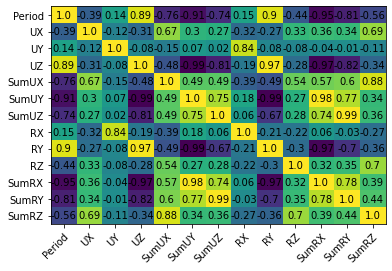

In [ ]:
corr = df_vibration.corr()
fig, ax = plt.subplots()


im = ax.imshow(corr.values, aspect='auto')


ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, np.around(corr.iloc[i, j], decimals=2),
                       ha="center", va="center", color="black")

## Arduino Data

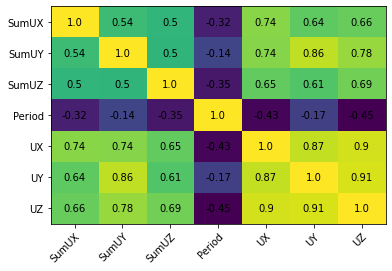

In [ ]:
corr = df_arduino.corr()
fig, ax = plt.subplots()


im = ax.imshow(corr.values, aspect='auto')


ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, np.around(corr.iloc[i, j], decimals=2),
                       ha="center", va="center", color="black")

# Defining Input and Target Value(Target value is UX)

# Splitting dataset into train and test

In [ ]:
train_dataset_arduino = df_arduino.sample(frac=0.9,random_state=0)
test_dataset_arduino = df_arduino.drop(train_dataset_arduino.index)

train_dataset_vibration = df_vibration.sample(frac=0.9,random_state=0)
test_dataset_vibration = df_vibration.drop(train_dataset_vibration.index)


In [ ]:
train_input_vibration = train_dataset_vibration.drop(['UX'], axis=1)
train_target_vibration = train_dataset_vibration['UX']
test_input_vibration = test_dataset_vibration.drop(['UX'], axis=1)
test_target_vibration = test_dataset_vibration['UX']

train_input_arduino = train_dataset_arduino.drop(['UX'], axis=1)
train_target_arduino = train_dataset_arduino['UX']
test_input_arduino = test_dataset_arduino.drop(['UX'], axis=1)
test_target_arduino = test_dataset_arduino['UX']

# Size of training and test datasets

In [ ]:
print("Vibration Dataset Size: "+ str(len(df_vibration))+ 
      "            Arduino Dataset Size: " + str(len(df_arduino)))
print("Vibration Training Dataset Size: "+ str(len(train_dataset_vibration)) + 
      "   Arduino Training Dataset Size: "+ str(len(train_dataset_arduino)))
print("Vibration Testing Dataset Size: "+ str(len(test_dataset_vibration)) + 
      "     Arduino Testing Dataset Size: "+ str(len(test_dataset_arduino)))


Vibration Dataset Size: 1342            Arduino Dataset Size: 1300
Vibration Training Dataset Size: 1208   Arduino Training Dataset Size: 1170
Vibration Testing Dataset Size: 134     Arduino Testing Dataset Size: 130


# Creating and Training Model(Download Model if created previously)


## Vibration

In [ ]:
# firebase_model_get = ml.get_model(model_id)
model = tf.keras.Sequential([tf.keras.layers.
                             Dense(64,
                                   activation="relu", 
                                   input_shape=
                                   [(len(train_input_vibration.keys()))]                      
                                                                         ),
                                   tf.keras.layers.Dense(64,activation ='relu'),
                                   tf.keras.layers.Dense(1),
                                                       ])
model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
    name='Adam'),
                metrics=['mae', 'mse'])
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=60,
                                                 min_delta=0.01)  


EPOCHS = 1000
model.summary()
hst = model.fit(
  train_input_vibration, train_target_vibration,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[earlyStopping,tfdocs.modeling.EpochDots()])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:0.0282,  mae:0.1062,  mse:0.0282,  val_loss:0.0011,  val_mae:0.0275,  val_mse:0.0011,  
.............................................................

## Arduino

In [ ]:
# firebase_model_get = ml.get_model(model_id)
model_arduino = tf.keras.Sequential([tf.keras.layers.
                             Dense(128,
                                   activation="relu", 
                                   input_shape=[(len(train_input_arduino.keys()))], 
                                 
                                 ),
                                   tf.keras.layers.Dense(1),
                                                       ])
model_arduino.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
    name='Adam'),
                metrics=['mae', 'mse'])
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=250,
                                                 min_delta=0.01)  


EPOCHS = 1000
model_arduino.summary()
hst_arduino = model_arduino.fit(
  train_input_arduino, train_target_arduino,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[earlyStopping,tfdocs.modeling.EpochDots()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:17766620.0000,  mae:2949.1743,  mse:17766620.0000,  val_loss:522498.0312,  val_mae:589.6777,  val_mse:522498.0312,  
....................................................................................................
Epoch: 100, loss:13647.6436,  mae:87.0405,  mse:13647.6436,  val_loss:1553.4092,  val_mae:32.2082,  val_mse:1553.4092,  
....................................................................................................
Epoch: 200, loss:152.1143,  mae:9.5755,  mse:152.1143,  va

#Save models


In [ ]:
model.save('vibration_model') 
model_arduino.save('arduino_model')

INFO:tensorflow:Assets written to: vibration_model/assets
INFO:tensorflow:Assets written to: arduino_model/assets


#Load Models

In [ ]:
loaded_model = tf.keras.models.load_model('vibration_model')
loaded_arduino_model = tf.keras.models.load_model('arduino_model')
#model = loaded_model

#Results

## Vibration

In [ ]:
model.evaluate(test_input_vibration,test_target_vibration)

5/5 [==============================] - 0s 2ms/step - loss: 1.9964e-08 - mae: 1.1863e-04 - mse: 1.9964e-08


[1.996427911876708e-08, 0.00011862977407872677, 1.996427911876708e-08]

In [ ]:
pred = model.predict(test_input_vibration).flatten()
mse = tf.keras.metrics.MeanSquaredError()
mse.update_state(test_target_vibration,pred)
print('Mean Squared Error')
mse.result().numpy().round(8)

Mean Squared Error


2e-08

## Arduino

In [ ]:
model_arduino.evaluate(test_input_arduino,test_target_arduino)

5/5 [==============================] - 0s 2ms/step - loss: 97.5233 - mae: 7.1955 - mse: 97.5233


[97.52330780029297, 7.195464134216309, 97.52330780029297]

In [ ]:
pred_arduino = model_arduino.predict(test_input_arduino).flatten()
mse_arduino = tf.keras.metrics.MeanSquaredError()
mse_arduino.update_state(test_target_arduino,pred_arduino)
print('Mean Squared Error')
mse_arduino.result().numpy()

Mean Squared Error


97.52331

#Plotting Results

#Predicting UX

## Vibration

In [ ]:
pred = model.predict(test_input_vibration).flatten()
i = 0
for e in zip(test_target_vibration, pred):
  print(" Actual"+"    Predict")
  print(e)
  i+=1
  if i == 4:
    break

 Actual    Predict
(0.00033999999999999997, 0.00017634965)
 Actual    Predict
(1.932e-06, 0.00022650417)
 Actual    Predict
(3.997e-06, 0.00018888828)
 Actual    Predict
(2.225e-05, 2.5939662e-05)


## Arduino

In [ ]:
pred_arduino = model_arduino.predict(test_input_arduino).flatten()
i = 0
for e in zip(test_target_arduino.round(5), pred_arduino):
  print(" Actual"+"    Predict")
  print(e)
  i+=1
  if i == 9:
    break

 Actual    Predict
(29.05, 20.493252)
 Actual    Predict
(48.52, 49.477318)
 Actual    Predict
(32.11, 29.550175)
 Actual    Predict
(31.7, 43.594883)
 Actual    Predict
(47.91, 37.04197)
 Actual    Predict
(35.27, 28.960003)
 Actual    Predict
(44.55, 41.776257)
 Actual    Predict
(62.79, 57.08872)
 Actual    Predict
(23.65, 22.337658)


#Visualizing Results

## Vibration

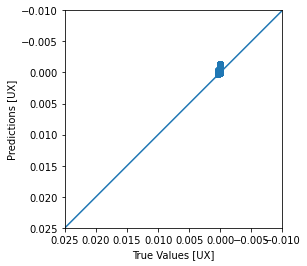

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_target_vibration, pred)
plt.xlabel('True Values [UX]')
plt.ylabel('Predictions [UX]')
lims = [0.0250, -0.01]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

##Arduino

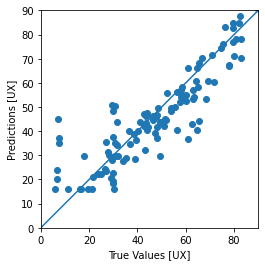

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_target_arduino, pred_arduino)
plt.xlabel('True Values [UX]')
plt.ylabel('Predictions [UX]')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_arduino = plt.plot(lims, lims)

##Vibration

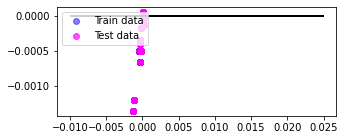

In [ ]:
pred_train = model.predict(train_input_vibration).flatten()
pred_test =  model.predict(test_input_vibration).flatten()
plt.figure(figsize=(5,2))

plt.scatter(
  pred_train,pred_train - train_target_vibration,
          c = 'blue', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(pred_test,pred_test - test_target_vibration,
          c = 'magenta', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')

plt.hlines(y = 0, xmin = -0.01, xmax = 0.0250, lw = 2, color = 'black')
plt.legend(loc = 'upper left')

## Arduino

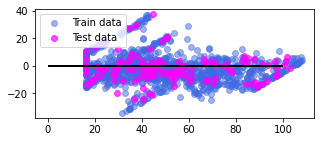

In [ ]:
pred_train_arduino = model_arduino.predict(train_input_arduino).flatten()
pred_test_arduino =  model_arduino.predict(test_input_arduino).flatten()
plt.figure(figsize=(5,2))

plt.scatter(
  pred_train_arduino,pred_train_arduino - train_target_arduino,
          c = 'royalblue', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(pred_test_arduino,pred_test_arduino - test_target_arduino,
          c = 'magenta', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')

plt.hlines(y = 0, xmin = 0, xmax = 100, lw = 2, color = 'black')
plt.legend(loc = 'upper left')

#Conclusion

**Since Mean Squared Error is our main comparison parameter, 
                  vibration data model performed better** 